# Cats and Dogs Toy Example

This notebook will train, quantize, and synthesis the Cats and Dogs example. We want to use this example to show that a high test set accuracy does not guarantee a high accuracy on the board.

### Import the necessary modules

In [2]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import distiller.apputils as apputils

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from cats_and_dogs import *

mod = importlib.import_module("cat-dog_net")

import ai8x
%matplotlib inline

## Define Helper Functions

In [3]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

## Create and Load the Datasets

In [4]:
args = Args(act_mode_8bit=False)
data_path = "../Datasets/cats_and_dogs/"

train_set, test_set = cats_and_dogs_get_datasets((data_path, args), load_train=True, load_test=True)

{'dogs': 0, 'cats': 1}
{'dogs': 0, 'cats': 1}


## Visualize a batch of training data

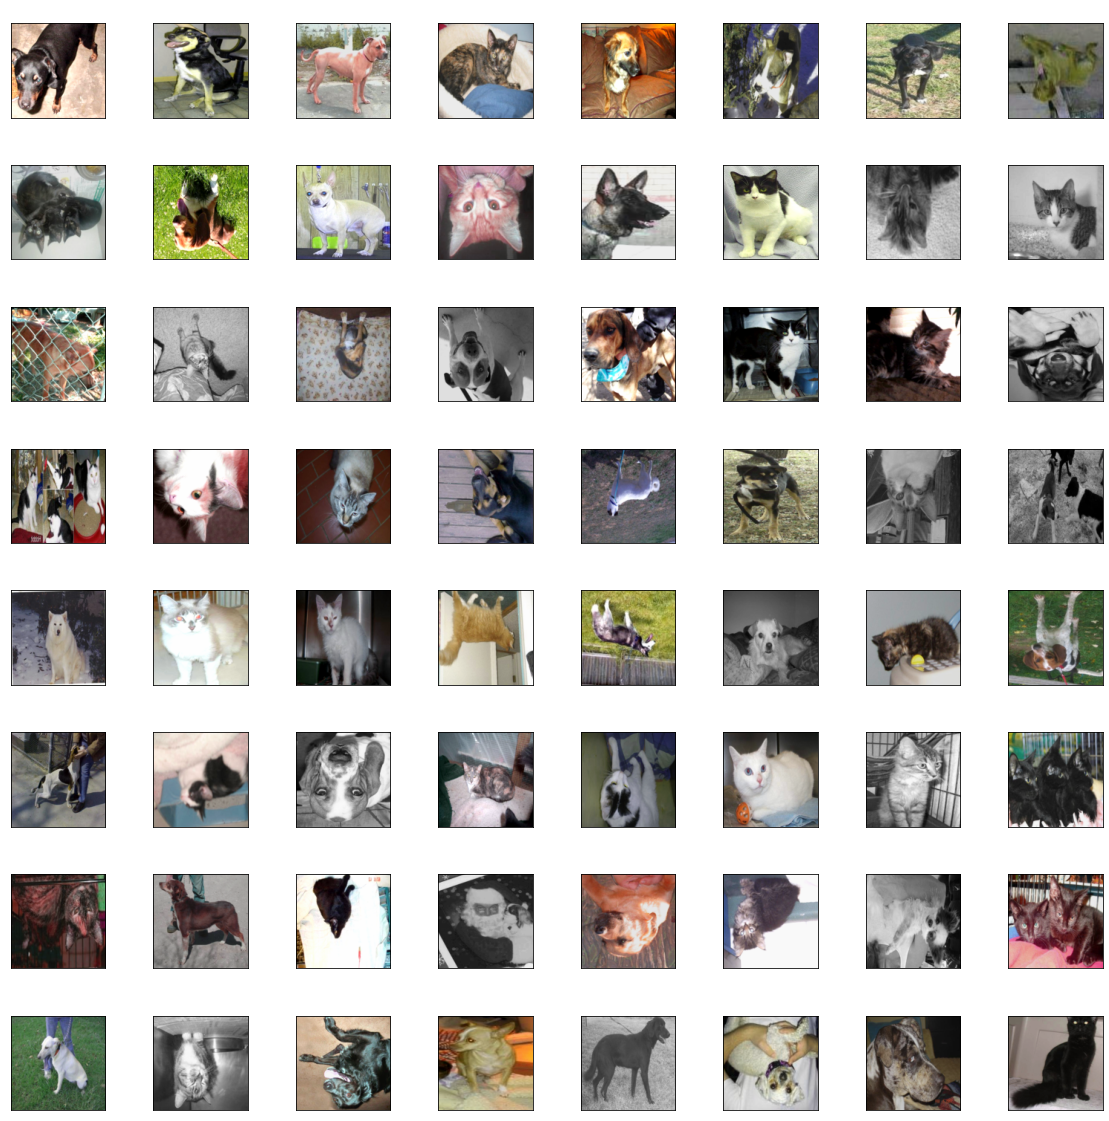

In [4]:
train_set.visualize_batch()

## Create the data loaders

In [5]:
batch_size = 64
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=True)

## Set up the device, cuda or cpu

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Set up the model for training

In [7]:
ai8x.set_device(device=85, simulate=False, round_avg=False)

model = mod.CatsAndDogsClassifier()
        
model = model.to(device)

print(f'Number of Model Params: {count_params(model)}')

Configuring device: MAX78000, simulate=False.
Number of Model Params: 279562


## Set up the training parameters

In [13]:
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.001)
ms_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 25], gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

qat_policy = {'start_epoch':5,
              'weight_bits':8}

## Run the trianing loop

In [14]:
best_acc = 0
best_qat_acc = 0
wrong_samples = None
wrong_preds = None
actual_preds = None
for epoch in range(0, num_epochs):
    if epoch > 0 and epoch == qat_policy['start_epoch']:
        print('QAT is starting!')
        # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
        ai8x.fuse_bn_layers(model)

        # Switch model from unquantized to quantized for QAT
        ai8x.initiate_qat(model, qat_policy)

        # Model is re-transferred to GPU in case parameters were added
        model.to(device)
    running_loss = []
    train_start = time.time()
    model.train()
    for idx, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.type(torch.long).to(device)
        optimizer.zero_grad()
        
        model_out = model(image)
        
        loss = criterion(model_out, label)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())

    mean_loss = np.mean(running_loss)
    train_end = time.time()
    print("Epoch: {}/{}\t LR: {}\t Train Loss: {:.4f}\t Dur: {:.2f} sec.".format(epoch+1, num_epochs, ms_lr_scheduler.get_lr(), mean_loss, (train_end-train_start)))
    
    model.eval()
    acc = 0.
    acc_weight = 0
    with torch.no_grad():
        for image, label in test_dataloader:
            image = image.to(device)
            label = label.type(torch.long).to(device)
            model_out = model(image)
            label_out = torch.argmax(model_out, dim=1)

            # display wrong outputs
            pred = model_out.argmax(dim=1, keepdim=True) # get the idxs of the max output
            wrong_idx = (pred != label.view_as(pred)).nonzero()[:, 0] # get wrong predictions
            wrong_samples = image[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = label.view_as(pred)[wrong_idx]
            
            # test_set.viz_mispredict(wrong_samples,wrong_preds,actual_preds)
            
            tp = torch.sum(label_out == label)
            acc_batch = (tp / label_out.numel()).detach().item()
            acc += label_out.shape[0] * acc_batch
            acc_weight += label_out.shape[0]
            
        total_acc = 100 * (acc / acc_weight)
        if epoch == qat_policy['start_epoch']: best_acc = 0
        if total_acc > best_acc:
            best_acc = total_acc
            checkpoint_extras = {'current_top1': best_acc,
                                 'best_top1': best_acc,
                                 'best_epoch': epoch}
            model_name = 'catdognet'
            model_prefix = f'{model_name}' if epoch < qat_policy['start_epoch'] else (f'qat_{model_name}')
            apputils.save_checkpoint(epoch, model_name, model, optimizer=optimizer,
                                     scheduler=None, extras=checkpoint_extras,
                                     is_best=True, name=model_prefix,
                                     dir='.')
            print(f'Best model saved with accuracy: {best_acc:.2f}%')
            
        print('\t\t Test Acc: {:.2f}'.format(total_acc))
        
    ms_lr_scheduler.step()
#test_set.visualize_batch(model,device)
test_set.viz_mispredict(wrong_samples,wrong_preds,actual_preds)


Epoch: 1/50	 LR: [0.001]	 Train Loss: 0.5406	 Dur: 66.33 sec.
Best model saved with accuracy: 73.54%
		 Test Acc: 73.54
Epoch: 2/50	 LR: [0.001]	 Train Loss: 0.4939	 Dur: 66.19 sec.
Best model saved with accuracy: 74.24%
		 Test Acc: 74.24
Epoch: 3/50	 LR: [0.001]	 Train Loss: 0.4489	 Dur: 65.86 sec.
Best model saved with accuracy: 76.34%
		 Test Acc: 76.34
Epoch: 4/50	 LR: [0.001]	 Train Loss: 0.4180	 Dur: 65.82 sec.
Best model saved with accuracy: 81.78%
		 Test Acc: 81.78
Epoch: 5/50	 LR: [0.001]	 Train Loss: 0.3776	 Dur: 66.05 sec.
		 Test Acc: 73.78
QAT is starting!
Epoch: 6/50	 LR: [0.00025]	 Train Loss: 0.5117	 Dur: 67.76 sec.
Best model saved with accuracy: 81.48%
		 Test Acc: 81.48
Epoch: 7/50	 LR: [0.0005]	 Train Loss: 0.3655	 Dur: 67.85 sec.
Best model saved with accuracy: 82.38%
		 Test Acc: 82.38
Epoch: 8/50	 LR: [0.0005]	 Train Loss: 0.3304	 Dur: 67.91 sec.
Best model saved with accuracy: 85.62%
		 Test Acc: 85.62
Epoch: 9/50	 LR: [0.0005]	 Train Loss: 0.3025	 Dur: 68.38 

## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [2]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py qat_catdognet_best.pth.tar qat_catdognet_best_q.pth.tar --device MAX78000 -v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Configuring device: MAX78000
Converting checkpoint file qat_catdognet_best.pth.tar to qat_catdognet_best_q.pth.tar

Model keys (state_dict):
conv1.output_shift, conv1.weight_bits, conv1.bias_bits, conv1.quantize_activation, conv1.adjust_output_shift, conv1.shift_quantile, conv1.op.weight, conv2.output_shift, conv2.weight_bits, conv2.bias_bits, conv2.quantize_activation, conv2.adjust_output_shift, conv2.shift_quantile, conv2.op.weight, conv3.output_shift, conv3.weight_bits, conv3.bias_bits, conv3.quantize_activation, conv3.adjust_output_shift, conv3.shift_quantile, conv3.op.weight, conv4.output_shift, conv4.weight_bits, conv4.bias_bits, conv4.quantize_activation, conv4.adjust_output_shift, conv4.shift_quantile, conv4.op.weight, conv4.op.bias, conv5.output_shift, conv5.weight_bits, conv5.bias_bits, conv5.quantize_activation, conv5.adjust_output_shift, conv5.shift_quantile, conv5.op.weight, conv5.op.bi

## Evaluate Quantized Model

Change virtual environment back to ai8x-training and rerun the first cell with the imports

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = 'qat_catdognet_best_q.pth.tar'
# Change this path to match file system layout
data_path = "../Datasets/cats_and_dogs/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.CatsAndDogsClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


In [4]:
args = Args(act_mode_8bit=True)

_, test_set = train_set, test_set = cats_and_dogs_get_datasets((data_path, args), load_train=True, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

{'dogs': 0, 'cats': 1}
{'dogs': 0, 'cats': 1}


In [5]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 91.58%


In [8]:
for image, label in test_dataloader:
    break

im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)

np.save('sample_cats_and_dogs.npy', im_sample)

## Model Synthesis

In [4]:
%run ../ai8x-synthesis/ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix cats_and_dogs --checkpoint-file qat_catdognet_best_q.pth.tar --config-file ../ai8x-synthesis/networks/cats_and_dogs.yaml --device MAX78000 --sample-input sample_cats_and_dogs.npy --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

usage: ai8xize.py [-h] (--ai85 | --device device-name) [--avg-pool-rounding]
                  [--simple1b] [-e | --rtl | --rtl-preload]
                  [--pipeline | --no-pipeline] [--pll | --no-pll]
                  --config-file S [--checkpoint-file S] [--board-name S]
                  [--display-checkpoint] --prefix S [--debugwait N]
                  [--define S] [--define-default-arm S]
                  [--define-default-riscv S] [--eclipse-includes S]
                  [--eclipse-variables S] [--eclipse-openocd-args S]
                  [--overwrite] [--compact-data] [--compact-weights]
                  [--mexpress] [--mlator] [--unroll-mlator N]
                  [--unroll-8bit N] [--unroll-wide N] [--softmax]
                  [--unload | --no-unload] [--no-kat] [--boost S]
                  [--start-layer N] [--no-wfi] [--timer N] [--no-timer]
                  [--energy] [--switch-delay N] [--output-width {8,32}]
                  [--c-filename S] [--api-filename S] [-

SystemExit: 2